# Setup


In [1]:
%pip install control
%pip install shapely

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import skfuzzy as fuzz


def gerar_tabela_verdade(fuzzy_sim, e, delta_e, delta_u):
    # Gerando todas as combinações de entradas e calculando as saídas
    results = []
    for e_val in e.terms:
        row = []
        for delta_e_val in delta_e.terms:
            fuzzy_sim.input["e"] = e_val
            fuzzy_sim.input["delta_e"] = delta_e_val
            fuzzy_sim.compute()
            delta_u_val = fuzzy_sim.output["delta_u"]

            # Convertendo o valor de saída para o rótulo correspondente
            membership_values = {}
            for label in delta_u.terms:
                membership_values[label] = fuzz.interp_membership(delta_u.universe, delta_u[label].mf, delta_u_val)
            label = max(membership_values, key=membership_values.get)
            row.append(label)
        results.append(row)

    # Criando um DataFrame com os resultados
    columns = delta_e.terms.keys()
    index = e.terms.keys()
    df = pd.DataFrame(results, columns=columns, index=index)

    # Adicionando a coluna de índice como "e[k] / Δe[k]"
    df.columns.name = "e[k] / Δe[k]"

    return df

In [3]:
from math import pi
import numpy as np
import matplotlib.pyplot as plt

# Definição dos parâmetros do motor
Pmec = 95 * 10**3
n = 0.913
Vn = 400
Wn = 1890 * pi / 30
Ra = 0.08
J = 0.56
La = 1.4 * 10**-3

Pele = Pmec / n
Cmn = Pmec / Wn
Ian = Pele / Vn
Kf = (Vn - Ian * Ra) / Wn
B = (Kf * Ian - Cmn) / Wn
Tm = J / B
Te = La / Ra
T = Te / 10

# Definição das matrizes A, B e C
A = np.array([[1 - T / Te, -Kf * T / La], [Kf * T / J, 1 - T / Tm]])
B = np.array([[T / La, 0], [0, -T / J]])


def simular_resposta_fuzzy(fuzzy_sim, setpoint, K, com_delta_e=True, plot=True):
    # Definição de parâmetros
    x = np.zeros((2, 1))
    u = np.zeros((2, 1))
    N = int(5 / T)

    W, Ia, t = [0] * (N + 1), [0] * (N + 1), np.linspace(0, 5, N + 1).tolist()
    errors, delta_errors, signals = [0] * (N + 1), [0] * (N + 1), [0] * (N + 1)

    Kp, Ki = K

    for i in range(N):
        # Cálculo do erro
        curr_error = (setpoint - W[i]) / setpoint * 100
        errors[i] = curr_error

        # Entrada do controlador fuzzy
        fuzzy_sim.input["e"] = curr_error * Ki

        if com_delta_e:
            delta_errors[i] = errors[i - 1] - curr_error if i > 0 else 0
            fuzzy_sim.input["delta_e"] = delta_errors[i] * Kp

        # Processa controle fuzzy
        fuzzy_sim.compute()

        # Sinal de controle
        control_signal_current = min(400, signals[i] + fuzzy_sim.output["delta_u"])
        signals[i + 1] = control_signal_current

        # Atualiza entrada do sistema
        u[0, 0] = control_signal_current

        # Cálculo da saída
        x = A @ x + B @ u
        Ia[i + 1], W[i + 1] = x.flatten()

    if plot == False:
        return W, t, signals, errors

    # Mostrando os gráficos de velocidade, corrente, erros e sinais em uma matriz 2x2
    _, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 6))

    # Gráfico de Velocidade
    ax1.axhline(setpoint, color="b", linestyle="--", label="Setpoint")
    ax1.plot(t, W, color="r")
    ax1.set_title("Velocidade do eixo")
    ax1.set_xlabel("Tempo (s)")
    ax1.set_ylabel("Velocidade (rad/s)")
    ax1.set_yticks(np.arange(min(W), max(W) + 20, 15))
    ax1.tick_params(axis="y", labelsize=8)
    ax1.legend(["Velocidade"])

    # Gráfico de Sinais de Controle
    ax2.plot(t, signals, color="m")
    ax2.set_title("Sinais de Controle")
    ax2.set_xlabel("Tempo (s)")
    ax2.set_ylabel("Sinal de Controle")
    ax2.legend(["Sinal de Controle"])

    # Gráfico de Erros
    ax3.plot(t, errors, color="g")
    ax3.set_title("Erros")
    ax3.set_xlabel("Tempo (s)")
    ax3.set_ylabel("Erro")
    ax3.legend(["Erro"])

    # Gráfico de Delta Erros
    if not com_delta_e:
        delta_errors = np.zeros_like(t)
    ax4.plot(t, delta_errors, color="c")
    ax4.set_title("Delta Erros")
    ax4.set_xlabel("Tempo (s)")
    ax4.set_ylabel("Delta Erro")
    ax4.legend(["Delta Erro"])

    plt.tight_layout()
    plt.show()

    return W, t, signals, errors

# Controle PI tradicional


In [ ]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt

# Define the sampling time
T = 0.00175

# Define the transfer functions
num_gpz = [0.0058540, 0, 0]
den_gpz = [1, -1.9224928, 0.9337476]

gpz = ct.TransferFunction(num_gpz, den_gpz, T)
gpi = 0.15 * ct.TransferFunction([1, -0.95], [1, -1], T)
# gpid = 1 * ctrl.TransferFunction([1, -0.2], [1, -0.1], T)

# Compute the closed-loop transfer function
sys_open_loop = ct.series(gpz, gpi)  # C(s) * G(s)
sys_closed_loop = ct.feedback(sys_open_loop, 1)

# Root locus plot
# Simulate system response to a 400V input and 0 load
time = np.arange(0, 5, T)
T_out, yout = ct.forced_response(sys_closed_loop, T=time, U=np.ones_like(time) * 300)

# Plot the response
plt.figure()
plt.plot(T_out, yout)
plt.xlabel("Tempo (s)")
plt.ylabel("Rad/s")
plt.title("Resposta do sistema ao setpoint 200 rad/s")
plt.grid()
plt.show()

# Controle PI Fuzzy


In [ ]:
import numpy as np
from skfuzzy import control as ctrl

# Definindo as variáveis fuzzy
e = ctrl.Antecedent(np.arange(-100, 100, 0.005), "e")
delta_e = ctrl.Antecedent(np.arange(-10, 10, 0.001), "delta_e")
delta_u = ctrl.Consequent(np.arange(-10, 10, 0.001), "delta_u")

# Definindo as funções de pertinência

CODIGOS = ["NG", "NM", "NP", "ZE", "PP", "PM", "PG"]

e.automf(names=CODIGOS)
delta_e.automf(names=CODIGOS)
delta_u.automf(names=CODIGOS)

# Criando as regras fuzzy
rules_1 = [
    ctrl.Rule(e["NG"] & delta_e["NG"], delta_u["NG"]),
    ctrl.Rule(e["NG"] & delta_e["NM"], delta_u["NG"]),
    ctrl.Rule(e["NG"] & delta_e["NP"], delta_u["NG"]),
    ctrl.Rule(e["NG"] & delta_e["ZE"], delta_u["NG"]),
    ctrl.Rule(e["NG"] & delta_e["PP"], delta_u["NM"]),
    ctrl.Rule(e["NG"] & delta_e["PM"], delta_u["NP"]),
    ctrl.Rule(e["NG"] & delta_e["PG"], delta_u["ZE"]),
    ctrl.Rule(e["NM"] & delta_e["NG"], delta_u["NG"]),
    ctrl.Rule(e["NM"] & delta_e["NM"], delta_u["NG"]),
    ctrl.Rule(e["NM"] & delta_e["NP"], delta_u["NG"]),
    ctrl.Rule(e["NM"] & delta_e["ZE"], delta_u["NM"]),
    ctrl.Rule(e["NM"] & delta_e["PP"], delta_u["NP"]),
    ctrl.Rule(e["NM"] & delta_e["PM"], delta_u["ZE"]),
    ctrl.Rule(e["NM"] & delta_e["PG"], delta_u["PP"]),
    ctrl.Rule(e["NP"] & delta_e["NG"], delta_u["NG"]),
    ctrl.Rule(e["NP"] & delta_e["NM"], delta_u["NG"]),
    ctrl.Rule(e["NP"] & delta_e["NP"], delta_u["NM"]),
    ctrl.Rule(e["NP"] & delta_e["ZE"], delta_u["NP"]),
    ctrl.Rule(e["NP"] & delta_e["PP"], delta_u["ZE"]),
    ctrl.Rule(e["NP"] & delta_e["PM"], delta_u["PP"]),
    ctrl.Rule(e["NP"] & delta_e["PG"], delta_u["PM"]),
    ctrl.Rule(e["ZE"] & delta_e["NG"], delta_u["NG"]),
    ctrl.Rule(e["ZE"] & delta_e["NM"], delta_u["NM"]),
    ctrl.Rule(e["ZE"] & delta_e["NP"], delta_u["NP"]),
    ctrl.Rule(e["ZE"] & delta_e["ZE"], delta_u["ZE"]),
    ctrl.Rule(e["ZE"] & delta_e["PP"], delta_u["PP"]),
    ctrl.Rule(e["ZE"] & delta_e["PM"], delta_u["PM"]),
    ctrl.Rule(e["ZE"] & delta_e["PG"], delta_u["PG"]),
    ctrl.Rule(e["PP"] & delta_e["NG"], delta_u["NM"]),
    ctrl.Rule(e["PP"] & delta_e["NM"], delta_u["NP"]),
    ctrl.Rule(e["PP"] & delta_e["NP"], delta_u["ZE"]),
    ctrl.Rule(e["PP"] & delta_e["ZE"], delta_u["PP"]),
    ctrl.Rule(e["PP"] & delta_e["PP"], delta_u["PM"]),
    ctrl.Rule(e["PP"] & delta_e["PM"], delta_u["PG"]),
    ctrl.Rule(e["PP"] & delta_e["PG"], delta_u["PG"]),
    ctrl.Rule(e["PM"] & delta_e["NG"], delta_u["NP"]),
    ctrl.Rule(e["PM"] & delta_e["NM"], delta_u["ZE"]),
    ctrl.Rule(e["PM"] & delta_e["NP"], delta_u["PP"]),
    ctrl.Rule(e["PM"] & delta_e["ZE"], delta_u["PM"]),
    ctrl.Rule(e["PM"] & delta_e["PP"], delta_u["PG"]),
    ctrl.Rule(e["PM"] & delta_e["PM"], delta_u["PG"]),
    ctrl.Rule(e["PM"] & delta_e["PG"], delta_u["PG"]),
    ctrl.Rule(e["PG"] & delta_e["NG"], delta_u["ZE"]),
    ctrl.Rule(e["PG"] & delta_e["NM"], delta_u["PP"]),
    ctrl.Rule(e["PG"] & delta_e["NP"], delta_u["PM"]),
    ctrl.Rule(e["PG"] & delta_e["ZE"], delta_u["PG"]),
    ctrl.Rule(e["PG"] & delta_e["PP"], delta_u["PG"]),
    ctrl.Rule(e["PG"] & delta_e["PM"], delta_u["PG"]),
    ctrl.Rule(e["PG"] & delta_e["PG"], delta_u["PG"]),
]

# Criando o sistema de controle
control_system = ctrl.ControlSystem(rules_1)

# Simulando o sistema
fuzzy_sim = ctrl.ControlSystemSimulation(control_system)

gerar_tabela_verdade(fuzzy_sim, e, delta_e, delta_u)

e.view()
delta_e.view()

In [ ]:
W, t, signals, errors = simular_resposta_fuzzy(fuzzy_sim, 100, [0.2, 0.1])

# Teste


In [79]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
from skfuzzy import control as ctrl


def generate_race_track():
    # Define key control points for the track (mix of curves and straights)
    control_points = (
        np.array(
            [
                [0, 0],
                [2, 1],
                [4, 1],  # First straight
                [6, 2],
                [7, 5],
                [6, 6],  # First curve
                [4, 7],
                [2, 7],
                [0, 6],  # Second straight
                [-2, 5],
                [-4, 4],
                [-2, 1],  # Second curve
                [0, 0],  # Close the loop
            ]
        ).T
        * 1000
    )  # Transpose for compatibility

    # Generate a smooth spline curve through control points
    tck, u = splprep(control_points, s=0, per=True)  # Closed curve
    u_fine = np.linspace(0, 1, 5000)  # Increased number of points for smoothness
    smooth_track = splev(u_fine, tck)

    return smooth_track[:2]


def generate_road_limits(race_track, width=4):
    """
    Gera os limites interno e externo da estrada com largura constante.
    """
    x, y = race_track

    # Calcular a direção tangente à pista
    dx = np.gradient(x)
    dy = np.gradient(y)

    # Calcular a direção perpendicular (vetor normal)
    norm = np.sqrt(dx**2 + dy**2)
    nx = -dy / norm
    ny = dx / norm

    # Calcular os limites interno e externo
    x_inner = x - nx * width / 2
    y_inner = y - ny * width / 2
    x_outer = x + nx * width / 2
    y_outer = y + ny * width / 2

    return np.column_stack((x_inner, y_inner, x_outer, y_outer))


# Gerar os pontos suavizados da pista
race_track = generate_race_track()

# Gerar os limites da estrada com largura constante de 20 metros
limits = generate_road_limits(race_track)

In [80]:
class FuzzyCar:
    def __init__(self, width, length, max_speed=10):
        self.width = width
        self.length = length
        self.max_speed = max_speed
        self.curr_speed = 0
        self.curr_angle = -np.pi / 2
        self.current_pos = (0, 0)
        self.state = pd.DataFrame(
            [[0, 0, 0, 0, *self.velocity()]],
            columns=["Proximity Diff.", "Delta Diff.", "Delta Angle", "Acceleration", "Speed", "Angle"],
        )

        proximity_diff = ctrl.Antecedent(np.arange(-0.5, 0.51, 0.001), "proximity_diff")
        delta_diff = ctrl.Antecedent(np.arange(-0.05, 0.051, 0.0001), "delta_diff")

        acceleration = ctrl.Consequent(np.arange(-0.1, 0.1, 0.001), "acceleration")

        # Positivo: margem direita mais próxima
        proximity_diff.automf(names=["NG", "NM", "NP", "ZE", "PP", "PM", "PG"])
        delta_diff.automf(names=["NG", "NM", "NP", "ZE", "PP", "PM", "PG"])

        # Positivo: sentido anti-horário
        max_radian = 15 * np.pi / 180  # 15 degrees in radians

        # Create the antecedent
        delta_angle = ctrl.Consequent(np.arange(-max_radian, max_radian, 0.001), "angle")

        delta_angle.automf(names=["NG", "NM", "NP", "ZE", "PP", "PM", "PG"])
        acceleration.automf(names=["NG", "NM", "NP", "ZE", "PP", "PM", "PG"])

        rules = [
            # Angulação
            # ctrl.Rule(proximity_diff["NG"], delta_angle["NG"]),
            # ctrl.Rule(proximity_diff["NM"], delta_angle["NM"]),
            # ctrl.Rule(proximity_diff["NP"], delta_angle["NP"]),
            # ctrl.Rule(proximity_diff["ZE"], delta_angle["ZE"]),
            # ctrl.Rule(proximity_diff["PP"], delta_angle["PP"]),
            # ctrl.Rule(proximity_diff["PM"], delta_angle["PM"]),
            # ctrl.Rule(proximity_diff["PG"], delta_angle["PG"]),
            # Aceleração
            # ctrl.Rule(proximity_diff["NG"], acceleration["NM"]),
            # ctrl.Rule(proximity_diff["NM"], acceleration["NP"]),
            # ctrl.Rule(proximity_diff["NP"], acceleration["PP"]),
            # ctrl.Rule(proximity_diff["ZE"], acceleration["PM"]),
            # ctrl.Rule(proximity_diff["PP"], acceleration["PP"]),
            # ctrl.Rule(proximity_diff["PM"], acceleration["NP"]),
            # ctrl.Rule(proximity_diff["PG"], acceleration["NM"]),
            ctrl.Rule(proximity_diff["NG"] & delta_diff["NG"], (delta_angle["NG"], acceleration["NG"])),
            ctrl.Rule(proximity_diff["NG"] & delta_diff["NM"], (delta_angle["NG"], acceleration["NG"])),
            ctrl.Rule(proximity_diff["NG"] & delta_diff["NP"], (delta_angle["NG"], acceleration["NG"])),
            ctrl.Rule(proximity_diff["NG"] & delta_diff["ZE"], (delta_angle["NG"], acceleration["NG"])),
            ctrl.Rule(proximity_diff["NG"] & delta_diff["PP"], (delta_angle["NM"], acceleration["NG"])),
            ctrl.Rule(proximity_diff["NG"] & delta_diff["PM"], (delta_angle["NP"], acceleration["NG"])),
            ctrl.Rule(proximity_diff["NG"] & delta_diff["PG"], (delta_angle["ZE"], acceleration["NG"])),
            ctrl.Rule(proximity_diff["NM"] & delta_diff["NG"], (delta_angle["NG"], acceleration["NM"])),
            ctrl.Rule(proximity_diff["NM"] & delta_diff["NM"], (delta_angle["NG"], acceleration["NM"])),
            ctrl.Rule(proximity_diff["NM"] & delta_diff["NP"], (delta_angle["NG"], acceleration["NM"])),
            ctrl.Rule(proximity_diff["NM"] & delta_diff["ZE"], (delta_angle["NM"], acceleration["NM"])),
            ctrl.Rule(proximity_diff["NM"] & delta_diff["PP"], (delta_angle["NP"], acceleration["NM"])),
            ctrl.Rule(proximity_diff["NM"] & delta_diff["PM"], (delta_angle["ZE"], acceleration["NM"])),
            ctrl.Rule(proximity_diff["NM"] & delta_diff["PG"], (delta_angle["PP"], acceleration["NM"])),
            ctrl.Rule(proximity_diff["NP"] & delta_diff["NG"], (delta_angle["NG"], acceleration["PP"])),
            ctrl.Rule(proximity_diff["NP"] & delta_diff["NM"], (delta_angle["NG"], acceleration["PP"])),
            ctrl.Rule(proximity_diff["NP"] & delta_diff["NP"], (delta_angle["NM"], acceleration["PP"])),
            ctrl.Rule(proximity_diff["NP"] & delta_diff["ZE"], (delta_angle["NP"], acceleration["PP"])),
            ctrl.Rule(proximity_diff["NP"] & delta_diff["PP"], (delta_angle["ZE"], acceleration["PP"])),
            ctrl.Rule(proximity_diff["NP"] & delta_diff["PM"], (delta_angle["PP"], acceleration["PP"])),
            ctrl.Rule(proximity_diff["NP"] & delta_diff["PG"], (delta_angle["PM"], acceleration["PP"])),
            ctrl.Rule(proximity_diff["ZE"] & delta_diff["NG"], (delta_angle["NG"], acceleration["PM"])),
            ctrl.Rule(proximity_diff["ZE"] & delta_diff["NM"], (delta_angle["NM"], acceleration["PM"])),
            ctrl.Rule(proximity_diff["ZE"] & delta_diff["NP"], (delta_angle["NP"], acceleration["PG"])),
            ctrl.Rule(proximity_diff["ZE"] & delta_diff["ZE"], (delta_angle["ZE"], acceleration["PG"])),
            ctrl.Rule(proximity_diff["ZE"] & delta_diff["PP"], (delta_angle["PP"], acceleration["PG"])),
            ctrl.Rule(proximity_diff["ZE"] & delta_diff["PM"], (delta_angle["PM"], acceleration["PM"])),
            ctrl.Rule(proximity_diff["ZE"] & delta_diff["PG"], (delta_angle["PG"], acceleration["PM"])),
            ctrl.Rule(proximity_diff["PP"] & delta_diff["NG"], (delta_angle["NM"], acceleration["PP"])),
            ctrl.Rule(proximity_diff["PP"] & delta_diff["NM"], (delta_angle["NP"], acceleration["PP"])),
            ctrl.Rule(proximity_diff["PP"] & delta_diff["NP"], (delta_angle["ZE"], acceleration["PP"])),
            ctrl.Rule(proximity_diff["PP"] & delta_diff["ZE"], (delta_angle["PP"], acceleration["PP"])),
            ctrl.Rule(proximity_diff["PP"] & delta_diff["PP"], (delta_angle["PM"], acceleration["PP"])),
            ctrl.Rule(proximity_diff["PP"] & delta_diff["PM"], (delta_angle["PG"], acceleration["PP"])),
            ctrl.Rule(proximity_diff["PP"] & delta_diff["PG"], (delta_angle["PG"], acceleration["PP"])),
            ctrl.Rule(proximity_diff["PM"] & delta_diff["NG"], (delta_angle["NP"], acceleration["PP"])),
            ctrl.Rule(proximity_diff["PM"] & delta_diff["NM"], (delta_angle["ZE"], acceleration["NM"])),
            ctrl.Rule(proximity_diff["PM"] & delta_diff["NP"], (delta_angle["PP"], acceleration["NM"])),
            ctrl.Rule(proximity_diff["PM"] & delta_diff["ZE"], (delta_angle["PM"], acceleration["NM"])),
            ctrl.Rule(proximity_diff["PM"] & delta_diff["PP"], (delta_angle["PG"], acceleration["NM"])),
            ctrl.Rule(proximity_diff["PM"] & delta_diff["PM"], (delta_angle["PG"], acceleration["NM"])),
            ctrl.Rule(proximity_diff["PM"] & delta_diff["PG"], (delta_angle["PG"], acceleration["NM"])),
            ctrl.Rule(proximity_diff["PG"] & delta_diff["NG"], (delta_angle["ZE"], acceleration["NG"])),
            ctrl.Rule(proximity_diff["PG"] & delta_diff["NM"], (delta_angle["PP"], acceleration["NG"])),
            ctrl.Rule(proximity_diff["PG"] & delta_diff["NP"], (delta_angle["PM"], acceleration["NG"])),
            ctrl.Rule(proximity_diff["PG"] & delta_diff["ZE"], (delta_angle["PG"], acceleration["NG"])),
            ctrl.Rule(proximity_diff["PG"] & delta_diff["PP"], (delta_angle["PG"], acceleration["NG"])),
            ctrl.Rule(proximity_diff["PG"] & delta_diff["PM"], (delta_angle["PG"], acceleration["NG"])),
            ctrl.Rule(proximity_diff["PG"] & delta_diff["PG"], (delta_angle["PG"], acceleration["NG"])),
        ]

        # Criando o sistema de controle e simulacao
        control_system = ctrl.ControlSystem(rules)
        self.fuzzy_sim = ctrl.ControlSystemSimulation(control_system)
        # self.fuzzy_sim.input["proximity_diff"] = 0.0
        # self.fuzzy_sim.input["delta_diff"] = 0.0
        # self.fuzzy_sim.compute()
        # acceleration.view(sim=self.fuzzy_sim)

    def velocity(self):
        return np.array((self.curr_speed, self.curr_angle))

    def nearest_limit_points_diff(self, limits):
        inner_dists = np.sum(np.square(limits[:, :2] - self.current_pos), axis=1)
        outer_dists = np.sum(np.square(limits[:, 2:] - self.current_pos), axis=1)
        min_outer = np.sqrt(min(outer_dists))
        min_inner = np.sqrt(min(inner_dists))

        if min_outer > 4.5 or min_inner > 4.5:
            raise Exception("Fora da pista")

        return min_outer - min_inner

    def update_state(self, proximity_diff, delta_diff, delta_angle, accel):
        self.state.loc[len(self.state)] = np.array(
            [
                proximity_diff,
                delta_diff,
                delta_angle,
                accel,
                *self.velocity(),
            ]
        ).round(6)

    def update_position(self, limits):
        proximity_diff = self.nearest_limit_points_diff(limits)
        delta_diff = proximity_diff - self.state.values[-1][0]

        self.fuzzy_sim.input["proximity_diff"] = proximity_diff
        self.fuzzy_sim.input["delta_diff"] = delta_diff

        self.fuzzy_sim.compute()
        angle_delta = self.fuzzy_sim.output["angle"]
        accel = self.fuzzy_sim.output["acceleration"]

        self.update_state(proximity_diff, delta_diff, angle_delta, accel)

        self.curr_speed += accel
        self.curr_speed = np.clip(self.curr_speed, 0, self.max_speed)

        self.curr_angle += angle_delta

        self.current_pos = self.current_pos + self.curr_speed * np.array(
            [np.sin(self.curr_angle), np.cos(self.curr_angle)]
        )

        return self.current_pos


FuzzyCar(2, 4)

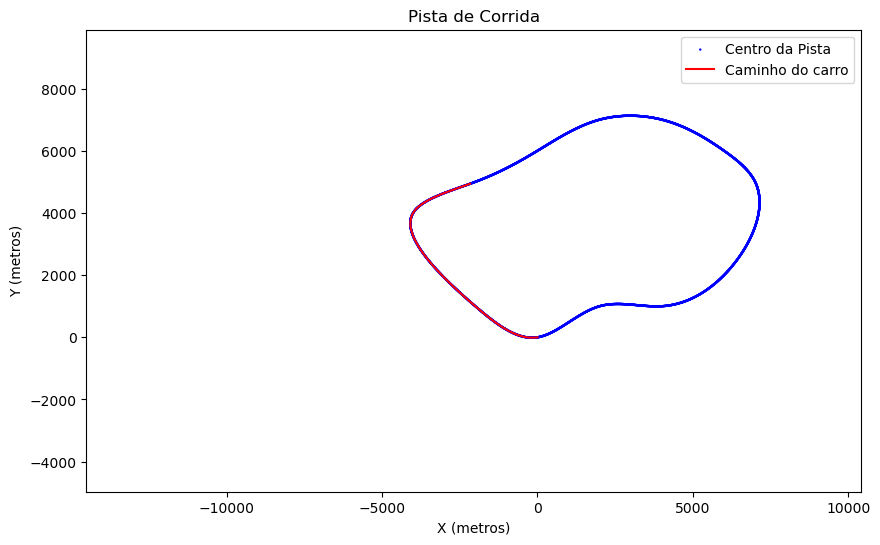

,Proximity Diff.,Delta Diff.,Delta Angle,Acceleration,Speed,Angle
0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.570796
1,-0.000000,-0.000000,-0.009102,0.082633,0.000000,-1.570796
2,-0.024359,-0.024359,-0.130809,0.061685,0.082633,-1.579898
3,-0.029174,-0.004815,-0.055800,0.062925,0.144318,-1.710707
4,-0.013075,0.016099,0.062693,0.072044,0.207243,-1.766507
...,...,...,...,...,...,...
4996,-0.685665,0.116869,-0.000299,-0.088942,1.974000,1.143878
4997,-0.257111,0.428554,0.126558,-0.020787,1.885058,1.143579
4998,-0.378850,-0.121739,-0.230968,-0.068055,1.864271,1.270137
4999,0.104220,0.483070,0.228723,0.046762,1.796216,1.039169


In [81]:
import numpy as np

car = FuzzyCar(2, 4)
car_path = []

for _ in range(len(race_track[0])):
    try:
        pos = car.update_position(limits)
    except Exception as e:
        if str(e) == "Fora da pista":
            print("FORA DA PISTA")
            break
        else:
            display(car.state)
            raise e

    car_path.append(pos)

car_path = np.array(car_path)


def calculate_plot_limits(car_path, margin=0.1):
    # Ensure car_path is a numpy array
    car_path = np.array(car_path)

    # Extract x and y coordinates
    x = car_path[:, 0]
    y = car_path[:, 1]

    # Calculate bounds for zooming
    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)

    # Add margin
    margin_x = margin * (x_max - x_min)
    margin_y = margin * (y_max - y_min)

    # Return the calculated limits
    return (x_min - margin_x, x_max + margin_x), (y_min - margin_y, y_max + margin_y)

# # Plotar a pista e os limites da estrada
xlim, ylim = calculate_plot_limits(car_path, margin=1)
plt.figure(figsize=(10, 6))
plt.scatter(race_track[0], race_track[1], label="Centro da Pista", color="blue", linestyle="--", s=0.5)
plt.plot(car_path[:, 0], car_path[:, 1], label="Caminho do carro", color="red")
# plt.plot(limits[:, 0], limits[:, 1], label="Limite Interno", color="green")
# plt.plot(limits[:, 2], limits[:, 3], label="Limite Externo", color="green")
plt.title("Pista de Corrida")
plt.xlabel("X (metros)")
plt.ylabel("Y (metros)")
plt.axis("equal")
plt.legend()

plt.xlim(xlim)
plt.ylim(ylim)

# Set equal aspect ratio
plt.show()
car.state

Max Speed: 2.380899


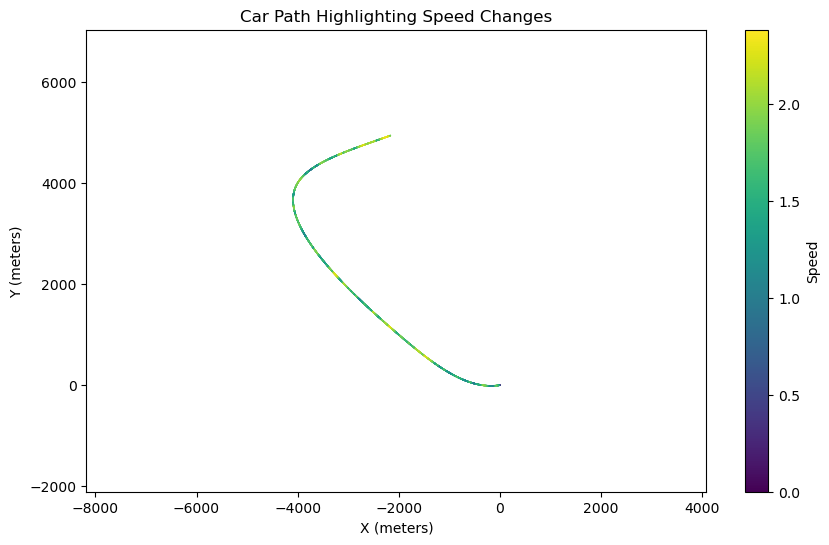

In [86]:
print("Max Speed:", car.state["Speed"].max())
# Extract speed data from the car state
speeds = car.state["Speed"].values

# Normalize speeds for color mapping
norm_speeds = (speeds - speeds.min()) / (speeds.max() - speeds.min())

# Create a plot with color representing speed
plt.figure(figsize=(10, 6))
for i in range(len(car_path) - 1):
    plt.plot(car_path[i:i+2, 0], car_path[i:i+2, 1], color=plt.cm.viridis(norm_speeds[i]), linewidth=1)

# Create a ScalarMappable object for the colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=speeds.min(), vmax=speeds.max()))
sm.set_array([])  # Only needed for older versions of matplotlib

plt.colorbar(sm, ax=plt.gca(), label='Speed')
plt.title("Car Path Highlighting Speed Changes")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.axis("equal")
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()